In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from adjustText import adjust_text

In [22]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
DRIVER_GENES = "../data/driver_genes"
PANGOLIN_PREDICTIONS = "../data/pangolin_predictions"
WHITELISTED_SAMPLES = "../data/datasets/PCAWG/supplementary Tables/Supplementary Table 1.csv"
GENE_NAME_MAPPING = "../data/ref/gene_mappings.tsv"

# output files
RECURRENT_SPLICING_MUTATIONS = "../results/recurrent_splicing_mutations.tsv"
PLOTS_DIR = "../results/PCAWG"
os.makedirs(PLOTS_DIR, exist_ok=True)
PLOT_DATA_DIR = "../plot_data/splicing_pangolin"
os.makedirs(PLOT_DATA_DIR, exist_ok=True)

CANCER_TYPES = os.listdir(PANGOLIN_PREDICTIONS)
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith("_pred.csv")]
CANCER_TYPES = [cancer_type.replace("_pred.csv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['Myeloid-AML', 'Lung-SCC', 'Prost-AdenoCA', 'Lymph-CLL', 'CNS-Oligo', 'CNS-Medullo', 'Breast-LobularCa', 'Kidney-ChRCC', 'ColoRect-AdenoCA', 'Panc-Endocrine', 'Eso-AdenoCa', 'Skin-Melanoma', 'Bone-Leiomyo', 'Biliary-AdenoCA', 'Uterus-AdenoCA', 'Head-SCC', 'Bone-Osteosarc', 'Liver-HCC', 'Lymph-BNHL', 'Panc-AdenoCA', 'Thy-AdenoCA', 'Kidney-RCC', 'Cervix-SCC', 'Breast-AdenoCa', 'CNS-PiloAstro', 'Lung-AdenoCA', 'Stomach-AdenoCA', 'CNS-GBM', 'Myeloid-MPN', 'Ovary-AdenoCA', 'Bladder-TCC']


In [23]:
gene_names = pd.read_csv(GENE_NAME_MAPPING, sep="\t")
# dictionary to map ensemble gene id to gene name
gene_dict = dict(zip(gene_names["ensembl_gene_id"], gene_names["hgnc_symbol"]))
print(len(gene_dict))

70611


In [24]:
whitelisted_data = pd.read_csv(WHITELISTED_SAMPLES, sep=",", header=0)
whitelisted_samples = whitelisted_data["tumour_specimen_aliquot_id"].unique().tolist()
print(f"Number of unique samples in the whitelist: {len(whitelisted_samples)}")

Number of unique samples in the whitelist: 2583


In [25]:
# get pangolin prediction
pangolin_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	pangolin_df_cancer = pd.read_csv(f"{PANGOLIN_PREDICTIONS}/{cancer_type}_pred.csv", sep="\t")
	pangolin_df_cancer.columns = ["data"]
	pangolin_df_cancer["mutation_loc"] = pangolin_df_cancer["data"].apply(lambda x: ':'.join(x.split(",")[:4]))
	pangolin_df_cancer["scores"] = pangolin_df_cancer["data"].apply(lambda x: x.split(",")[4:])
	pangolin_df_cancer = pangolin_df_cancer.drop(columns=["data"])
	pangolin_df_cancer["cancer_type"] = cancer_type
	pangolin_df = pd.concat([pangolin_df, pangolin_df_cancer], axis=0)
print(pangolin_df.shape)

# separate rows for scores for multiple genes
pangolin_df = pangolin_df.explode("scores")
print(pangolin_df.shape)

# drop rows with no scores
pangolin_df = pangolin_df[pangolin_df["scores"] != ""]
print(pangolin_df.shape)

# display warnings if any, clean up the data
pangolin_df["warning"] = pangolin_df["scores"].apply(lambda x: x.split("|Warnings:")[1] if "|Warnings:" in x else "")
pangolin_df["scores"] = pangolin_df["scores"].apply(lambda x: x.split("|Warnings:")[0])
warnings = pangolin_df[pangolin_df["warning"] != ""]["warning"].tolist()
if warnings:
	print(f"Warnings: {warnings}")
pangolin_df.drop(columns=["warning"], inplace=True)

# parse gene and scores
pangolin_df["splice_gene_id"] = pangolin_df["scores"].apply(lambda x: x.split("|")[0])
pangolin_df["scores"] = pangolin_df["scores"].apply(lambda x: x.split("|")[1:])
pangolin_df = pangolin_df.explode("scores")
pangolin_df["splice_pos"] = pangolin_df["scores"].apply(lambda x: x.split(":")[0]) # relative position
pangolin_df["splice_score"] = pangolin_df["scores"].apply(lambda x: x.split(":")[1])
pangolin_df.drop(columns=["scores"], inplace=True)
pangolin_df["splice_score"] = pangolin_df["splice_score"].astype(float)
# splice score of a variant is the maximum difference in probability scores 
# across tissues between the reference and mutated sequence
# pangolin paper mentions that at a cut-off of 0.14, false sign rate is 5%
pangolin_df = pangolin_df[abs(pangolin_df["splice_score"]) > 0.14]
print(pangolin_df.shape)

# get hgnc gene names
pangolin_df["splice_gene"] = pangolin_df["splice_gene_id"].apply(lambda x: \
									gene_dict[x.split('.')[0]] if x.split('.')[0] in gene_dict else None)
pangolin_df.drop(columns=["splice_gene_id"], inplace=True)

# splicing changes in the format gene:pos:score for each mutation
pangolin_df["splice_change"] = pangolin_df.apply(lambda x: f"{x['splice_gene']}:{x['splice_pos']}:{x['splice_score']}", axis=1)
pangolin_df.drop(columns=["splice_gene", "splice_pos", "splice_score"], inplace=True)
pangolin_df = pangolin_df.groupby(["mutation_loc"])["splice_change"].apply(lambda x: ','.join(x)).reset_index()
print(pangolin_df.shape)
pangolin_df.drop_duplicates(inplace=True)
print(pangolin_df.shape)
pangolin_df["splice_change"] = pangolin_df["splice_change"].apply(lambda x: x.split(","))
print(pangolin_df.shape)

(80018, 3)
(82675, 3)
(81734, 3)
Warnings: ['NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene', 'NoAnnotatedSitesToMaskForThisGene']
(980, 5)
(769, 2)
(769, 2)
(769, 2)


In [26]:
# get all mutations in driver genes
mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	mut_df_cancer = mut_df_cancer[mut_df_cancer["gene"].isin(driver_genes_list)]
	mut_df_cancer = mut_df_cancer[["Tumor_Sample_Barcode", "gene", "has_driver", "driver", "mutation_loc", "genic_region"]]
	mut_df_cancer["cancer_type"] = cancer_type
	mut_df = pd.concat([mut_df, mut_df_cancer], axis=0)

# get driver status
mut_df["driver_status"] = mut_df.apply(lambda x: "Passengers in presence of driver" if x["has_driver"] else "Passengers in absence of driver", axis=1)
mut_df["driver_status"] = mut_df.apply(lambda x: "Drivers" if x["driver"] else x["driver_status"], axis=1)
print(mut_df.shape)

# filter out samples that are not in the whitelist
mut_df = mut_df[mut_df["Tumor_Sample_Barcode"].isin(whitelisted_samples)]
print(mut_df.shape)

mut_df = pd.merge(mut_df, pangolin_df, on=["mutation_loc"], how="left")
print(mut_df.shape)
mut_df = mut_df.explode("splice_change")
print(mut_df.shape)

/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/2768101155.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/2768101155.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/2768101155.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/2768101155.py:4: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  mut_df_cancer = pd

(90258, 8)
(82512, 8)
(82512, 9)
(83269, 9)


In [27]:
# no. of splicing mutations for each cancer type
splicing_mut_cancer_count = mut_df.groupby("cancer_type")["splice_change"].apply(lambda x: x.nunique()).reset_index()
splicing_mut_cancer_count.columns = ["cancer_type", "num_splicing_mutations"]
splicing_mut_cancer_count.sort_values(by="num_splicing_mutations", ascending=False, inplace=True)

In [28]:
# genes having passenger mutations with large splicing effects in absence of drivers, for each cancer type
print(mut_df.shape)
splicing_large = mut_df[mut_df["splice_change"].notnull()] # only mutations with splicing changes
print(splicing_large.shape)
splicing_large = splicing_large[splicing_large["driver"] == False] # only passenger mutations
print(splicing_large.shape)
splicing_large = splicing_large[splicing_large["has_driver"] == False] # only passenger mutations in absence of driver
print(splicing_large.shape)
splicing_large["score"] = splicing_large["splice_change"].apply(lambda x: float(x.split(":")[2]))
splicing_large["abs_score"] = splicing_large["score"].abs()
splicing_large["change"] = splicing_large["score"].apply(lambda x: "gain" if x > 0 else "loss")
splicing_large = splicing_large.sort_values(by="abs_score", ascending=False)
splicing_large = splicing_large[["cancer_type", "gene", "abs_score", "change", "Tumor_Sample_Barcode"]]
splicing_large = splicing_large[(splicing_large["abs_score"] >= 0.5)] # filter for large splicing changes
print(splicing_large.shape)
splicing_large_cancer = splicing_large.groupby(["cancer_type", "gene", "change"]).agg({
    "Tumor_Sample_Barcode": "nunique",
}).reset_index()
splicing_large_cancer.columns = ["cancer_type", "gene", "change", "num_samples"]
splicing_large_cancer.sort_values(by="num_samples", ascending=False, inplace=True)
print(splicing_large_cancer.shape)

(83269, 9)
(1615, 9)
(622, 9)
(576, 9)
(138, 5)
(77, 4)


In [29]:
def get_percentage_samples(num, cancer_type):
	cancer_samples = mut_df[mut_df["cancer_type"] == cancer_type]
	num_cancer_samples = cancer_samples["Tumor_Sample_Barcode"].nunique()
	percent = round((num/num_cancer_samples)*100, 2)
	return percent

In [30]:
recurrent_splicing_mut = mut_df[~mut_df["driver"]] # only passengers
print(recurrent_splicing_mut.shape)
recurrent_splicing_mut.dropna(subset=["splice_change"], inplace=True)
print(recurrent_splicing_mut.shape)
recurrent_splicing_mut = recurrent_splicing_mut.groupby(["cancer_type", "mutation_loc"]).agg({
	"gene": "first",
    "genic_region": "first",
    "Tumor_Sample_Barcode": "count",
	"driver_status": lambda x: set(x),
	"splice_change": lambda x: set(x)
}).reset_index()
recurrent_splicing_mut.rename(columns={"Tumor_Sample_Barcode": "num_samples"}, inplace=True)
print(recurrent_splicing_mut.shape)
# percentage of samples with splicing mutations
recurrent_splicing_mut["percent_samples"] = recurrent_splicing_mut.apply(lambda x: get_percentage_samples(x["num_samples"], x["cancer_type"]), axis=1)
# highest splice score for each mutation
recurrent_splicing_mut["largest_splice_change"] = recurrent_splicing_mut["splice_change"].apply(lambda x: max([abs(float(y.split(":")[-1])) for y in x]))
recurrent_splicing_mut = recurrent_splicing_mut[recurrent_splicing_mut["num_samples"] > 1]
print(recurrent_splicing_mut.shape)
recurrent_splicing_mut.sort_values(by=["percent_samples", "num_samples"], ascending=False, inplace=True)
rec_splicing_save = recurrent_splicing_mut[['cancer_type', 'mutation_loc', 'gene', 'percent_samples', 'num_samples', 'largest_splice_change']]
rec_splicing_save.to_csv(RECURRENT_SPLICING_MUTATIONS, sep="\t", index=False)

(79232, 9)
(622, 9)
(532, 7)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/2707912719.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recurrent_splicing_mut.dropna(subset=["splice_change"], inplace=True)


(76, 9)


In [31]:
plot_df = mut_df[["mutation_loc", "driver_status", "gene", "splice_change", "cancer_type", "has_driver", "driver"]]
print(plot_df.shape)
num_mutations = plot_df.shape[0]
print("No. of mutations:", num_mutations)

plot_df.dropna(subset=["splice_change"], inplace=True)
print(plot_df.shape)
plot_df = plot_df.groupby(["splice_change", "mutation_loc", "driver_status", "driver", "has_driver", "gene"]).size().reset_index(name="count")
plot_df["pos"] = plot_df["splice_change"].apply(lambda x: int(x.split(":")[1]))
plot_df["splice_gene"] = plot_df["splice_change"].apply(lambda x: x.split(":")[0])
plot_df["score"] = plot_df["splice_change"].apply(lambda x: float(x.split(":")[2]))
plot_df["abs_score"] = plot_df["score"].abs()
plot_df["change"] = plot_df["score"].apply(lambda x: "gain" if x > 0 else "loss")
print(plot_df.shape)

(83269, 7)
No. of mutations: 83269
(1615, 7)
(871, 12)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/4263307590.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df.dropna(subset=["splice_change"], inplace=True)


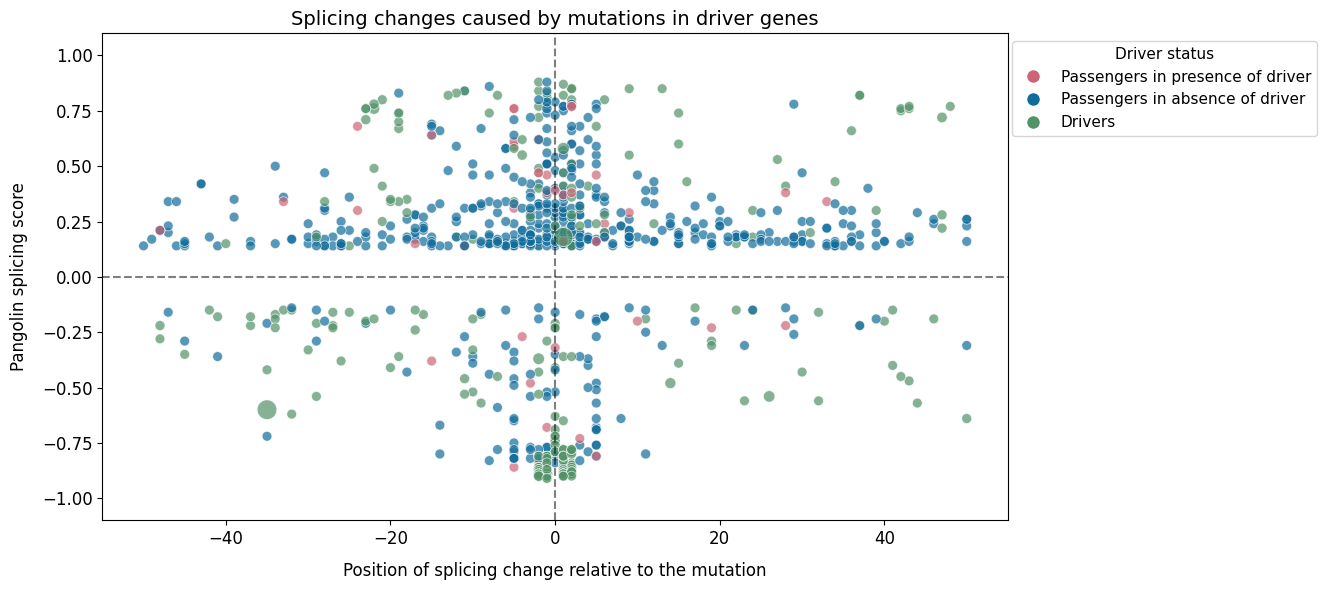

In [32]:
plt.figure(figsize=(14, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)

hue_order = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]

sns.scatterplot(
    x="pos", 
    y="score", 
    palette=cmap,
    hue="driver_status", 
	hue_order=hue_order,
	size="count",
	sizes=(50, 200),
    data=plot_df,
    alpha=0.7,
)
plt.axhline(y=0, linestyle='--', color="black", alpha=0.5)
plt.axvline(x=0, linestyle='--', color="black", alpha=0.5)

# formatting
plt.xlim(-55, 55)
plt.ylim(-1.1, 1.1)
plt.xticks(fontsize=12)
plt.xlabel("Position of splicing change relative to the mutation", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel("Pangolin splicing score", fontsize=12, labelpad=10)

# custom legend for driver status
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap[i], markersize=10) for i in range(3)]
plt.legend(handles, hue_order, title="Driver status", title_fontsize="11", fontsize="11", bbox_to_anchor=(1.35, 1), loc='upper right')

plt.title(f"Splicing changes caused by mutations in driver genes", fontsize=14)
plt.tight_layout()

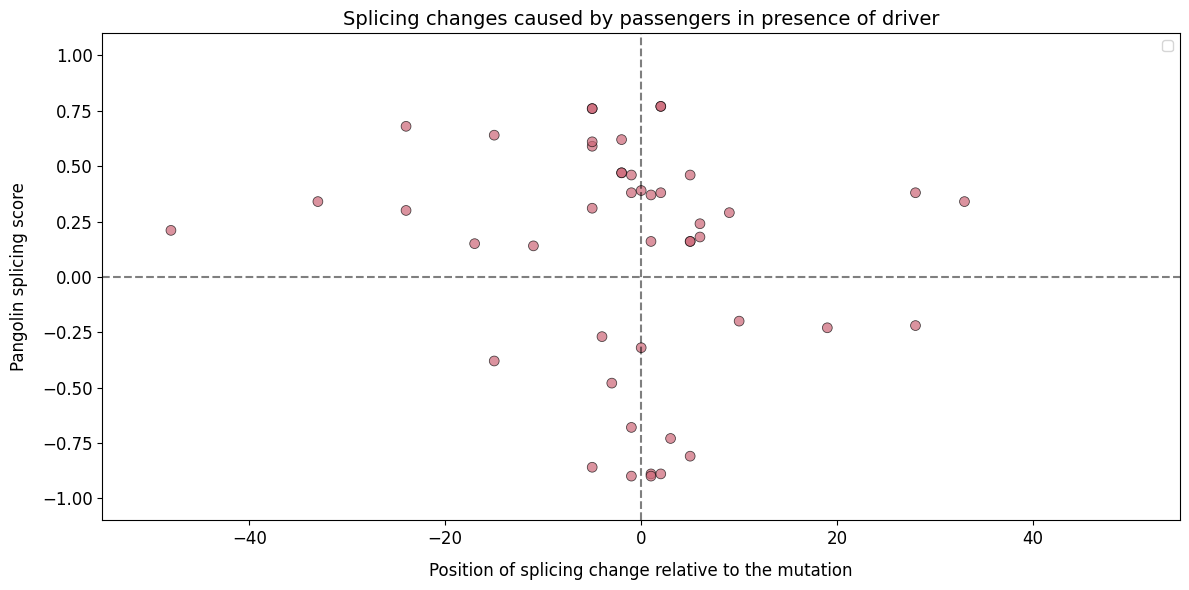

In [33]:
plot_df1 = plot_df[plot_df["driver_status"] == "Passengers in presence of driver"]
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="pos", 
    y="score", 
    palette=sns.color_palette([colors[0]]),
    hue="driver_status",
    data=plot_df1,
	size="count",
	sizes=(50, 200),
    alpha=0.7,
    edgecolor="black",
)
plt.axhline(y=0, linestyle='--', color="black", alpha=0.5)
plt.axvline(x=0, linestyle='--', color="black", alpha=0.5)

# formatting
plt.xlim(-55, 55)
plt.ylim(-1.1, 1.1)
plt.xticks(fontsize=12)
plt.xlabel("Position of splicing change relative to the mutation", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel("Pangolin splicing score", fontsize=12, labelpad=10)
plt.legend([])
plt.title(f"Splicing changes caused by passengers in presence of driver", fontsize=14)
plt.tight_layout()

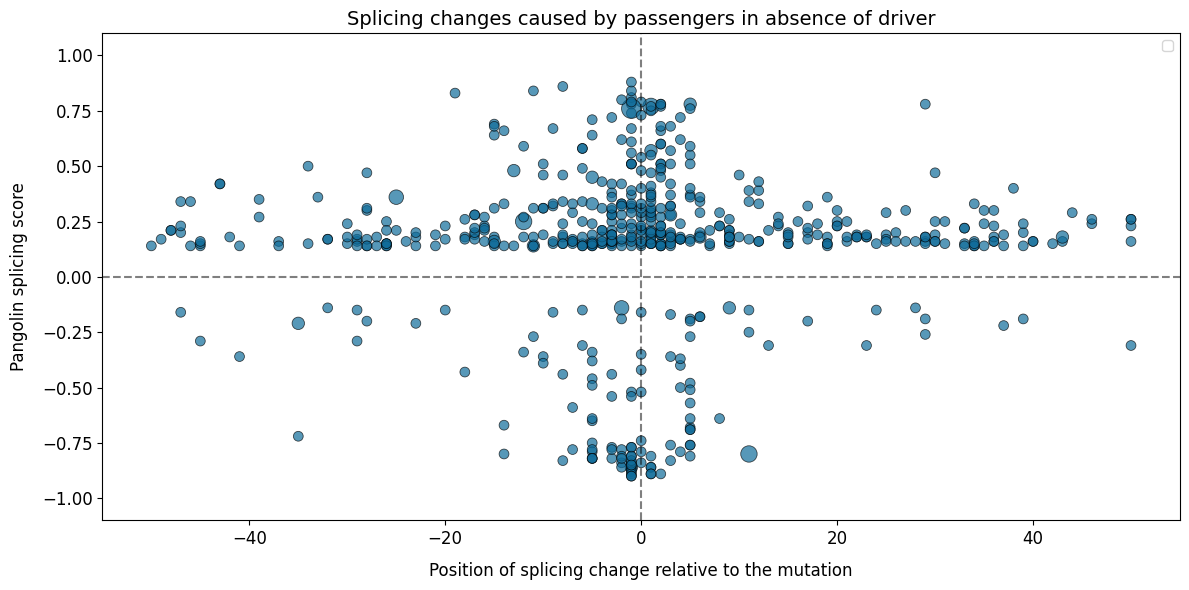

In [34]:
plot_df2 = plot_df[plot_df["driver_status"] == "Passengers in absence of driver"]
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x="pos", 
    y="score", 
    palette=sns.color_palette([colors[1]]),
    hue="driver_status",
    data=plot_df2,
	size="count",
	sizes=(50, 200),
    alpha=0.7,
    edgecolor="black",
)
plt.axhline(y=0, linestyle='--', color="black", alpha=0.5)
plt.axvline(x=0, linestyle='--', color="black", alpha=0.5)

# formatting
plt.xlim(-55, 55)
plt.ylim(-1.1, 1.1)
plt.xticks(fontsize=12)
plt.xlabel("Position of splicing change relative to the mutation", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)
plt.ylabel("Pangolin splicing score", fontsize=12, labelpad=10)
plt.legend([])
plt.title(f"Splicing changes caused by passengers in absence of driver", fontsize=14)
plt.tight_layout()

In [35]:
print(plot_df.shape)
large_splicing_effects = plot_df[plot_df["abs_score"] >= 0.2]
print(large_splicing_effects.shape)
large_splicing_effects.head()

(871, 12)
(624, 12)


,splice_change,mutation_loc,driver_status,driver,has_driver,gene,count,pos,splice_gene,score,abs_score,change
1,APC:-1:-0.8399999737739563,5:112155042:G:A,Drivers,True,True,APC,1,-1,APC,-0.84,0.84,loss
2,APC:-1:-0.9100000262260437,5:112162945:G:A,Drivers,True,True,APC,1,-1,APC,-0.91,0.91,loss
4,APC:-5:0.7599999904632568,5:112112916:A:G,Passengers in presence of driver,False,True,APC,1,-5,APC,0.76,0.76,gain
5,APC:1:-0.8799999952316284,5:112128142:G:T,Drivers,True,True,APC,1,1,APC,-0.88,0.88,loss
6,APC:33:0.3400000035762787,5:112154771:C:T,Passengers in presence of driver,False,True,APC,1,33,APC,0.34,0.34,gain


In [36]:
cancer_plot_df = mut_df[["mutation_loc", "driver_status", "gene", "splice_change", "cancer_type", "has_driver", "driver"]]
cancer_plot_df["organ"] = cancer_plot_df["cancer_type"].apply(lambda x: x.split("-")[0])
cancer_plot_df.dropna(subset=["splice_change"], inplace=True)
cancer_plot_df = cancer_plot_df.groupby(["splice_change", "organ", "mutation_loc", "driver_status", "driver", "has_driver", "gene"]).size().reset_index(name="count")
cancer_plot_df["pos"] = cancer_plot_df["splice_change"].apply(lambda x: int(x.split(":")[1]))
cancer_plot_df["splice_gene"] = cancer_plot_df["splice_change"].apply(lambda x: x.split(":")[0])
cancer_plot_df["score"] = cancer_plot_df["splice_change"].apply(lambda x: float(x.split(":")[2]))
cancer_plot_df["abs_score"] = cancer_plot_df["score"].abs()
cancer_plot_df["change"] = cancer_plot_df["score"].apply(lambda x: "gain" if x > 0 else "loss")
cancer_plot_df = cancer_plot_df[cancer_plot_df["abs_score"] >= 0.2]
print(cancer_plot_df.shape)

(681, 13)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/3278728212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_plot_df["organ"] = cancer_plot_df["cancer_type"].apply(lambda x: x.split("-")[0])
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/3278728212.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancer_plot_df.dropna(subset=["splice_change"], inplace=True)


/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/4204295712.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=19)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/4204295712.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=19)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/4204295712.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=19)
/var/folders/kb/00sgh9j520x459vtmckmbyjw0000gp/T/ipykernel_98996/4204295712.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

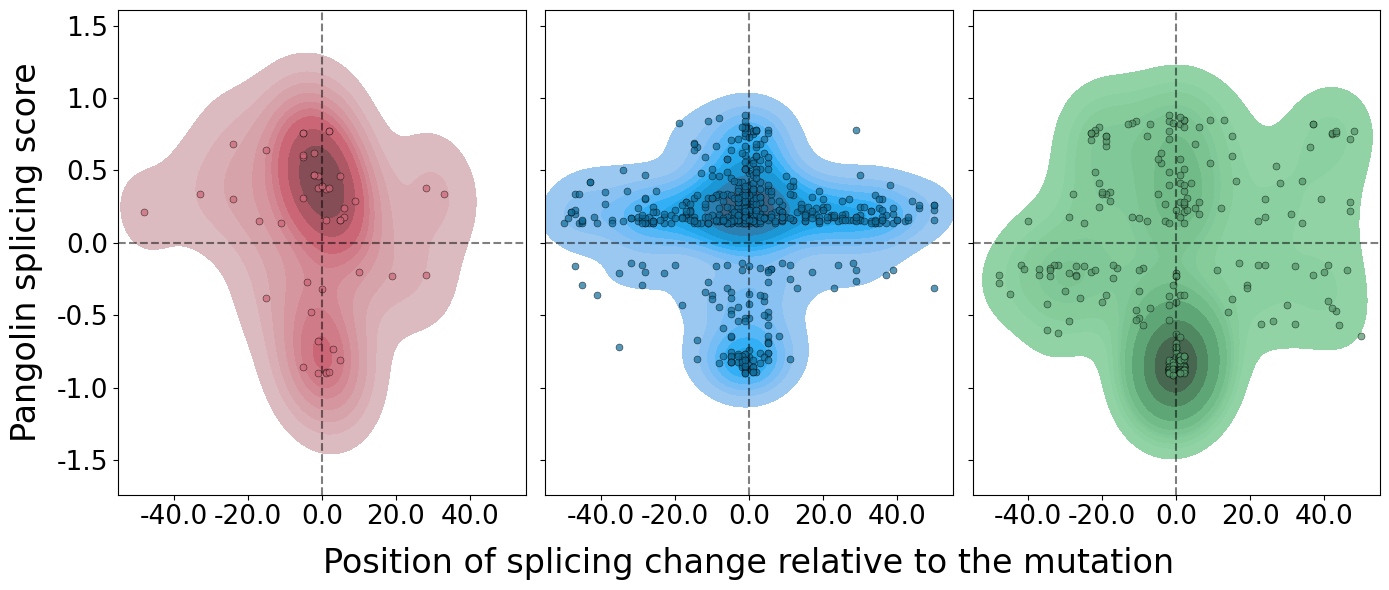

In [37]:
fig, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
driver_status = ["Passengers in presence of driver", "Passengers in absence of driver", "Drivers"]
for i, status in enumerate(driver_status):
	sns.kdeplot(
		x="pos", 
		y="score", 
		data=plot_df[plot_df["driver_status"] == status],
		ax=ax[i],
		color=colors[i],
		fill=True,
	)
	sns.scatterplot(
		x="pos", 
		y="score", 
		data=plot_df[plot_df["driver_status"] == status],
		ax=ax[i],
		color=colors[i],
		s=25,
		alpha=0.7,
		edgecolor="black",
	)
	ax[i].axhline(y=0, linestyle='--', color="black", alpha=0.5)
	ax[i].axvline(x=0, linestyle='--', color="black", alpha=0.5)
	ax[i].set_xlim(-55, 55)
	ax[i].set_xticklabels(ax[i].get_xticks(), fontsize=19)
	ax[i].set_yticklabels(ax[i].get_yticks(), fontsize=19)

ax[0].set_ylabel("Pangolin splicing score", fontsize=24, labelpad=10)
ax[0].set_xlabel("")
ax[2].set_xlabel("")
ax[1].set_xlabel("Position of splicing change relative to the mutation", fontsize=24, labelpad=12)
plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/splicing_changes_dist_by_driver_status.png", dpi=300)

# source data
plot_df[["pos", "score", "driver_status", "count"]].to_csv(f"{PLOT_DATA_DIR}/splicing_changes_dist_by_driver_status.tsv", sep="\t", index=False)

## Known Drivers with strong splicing effects

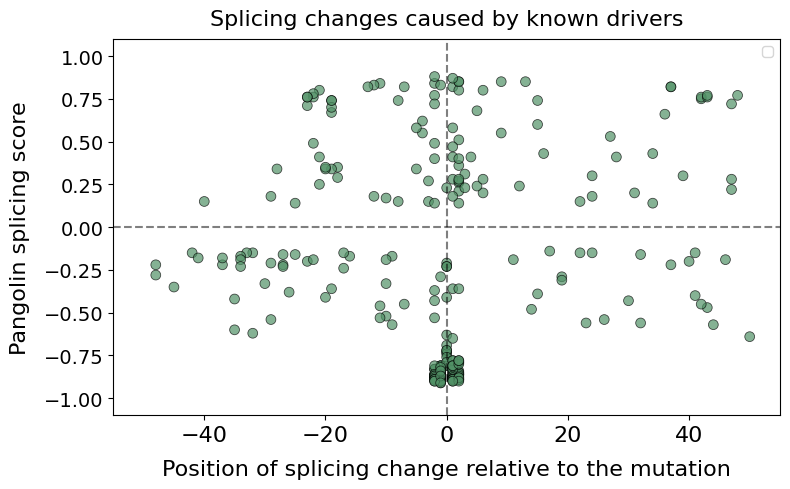

In [38]:
plot_df3 = plot_df[plot_df["driver_status"] == "Drivers"]

plt.figure(figsize=(8, 5))
sns.scatterplot(
    x="pos", 
    y="score", 
    palette=sns.color_palette([colors[2]]),
    hue="driver_status",
    data=plot_df3,
    s=50,
    alpha=0.7,
    edgecolor="black",
)
plt.axhline(y=0, linestyle='--', color="black", alpha=0.5)
plt.axvline(x=0, linestyle='--', color="black", alpha=0.5)

# formatting
plt.xlim(-55, 55)
plt.ylim(-1.1, 1.1)
plt.xticks(fontsize=16)
plt.xlabel("Position of splicing change relative to the mutation", fontsize=16, labelpad=10)
plt.yticks(fontsize=14)
plt.ylabel("Pangolin splicing score", fontsize=16, labelpad=10)
plt.legend([])
plt.title(f"Splicing changes caused by known drivers", fontsize=16, pad=10)
plt.tight_layout()

In [39]:
print(plot_df3.shape)
strong_effect_drivers = plot_df3[plot_df3["abs_score"] > 0.5]
print(strong_effect_drivers.shape)
print(f"No. of distinct mutations with strong splicing effects among drivers: {strong_effect_drivers['mutation_loc'].nunique()}")
print(f"No. of distinct genes with strong splicing effects among drivers: {strong_effect_drivers['gene'].nunique()}")
gene_splicing_counts = strong_effect_drivers.groupby("gene").agg({
    "mutation_loc": "nunique",
    "change": lambda x: set(x),
}).reset_index()
gene_splicing_counts.rename(columns={"mutation_loc": "num_splicing_mutations"}, inplace=True)
gene_splicing_counts.sort_values(by="num_splicing_mutations", ascending=False, inplace=True)
gene_splicing_counts["percent_splicing_mutations"] = round((gene_splicing_counts["num_splicing_mutations"] / gene_splicing_counts["num_splicing_mutations"].sum()) * 100, 2)
gene_splicing_counts.head()

(282, 12)
(173, 12)
No. of distinct mutations with strong splicing effects among drivers: 128
No. of distinct genes with strong splicing effects among drivers: 31


,gene,num_splicing_mutations,change,percent_splicing_mutations
28,TP53,45,"{loss, gain}",35.16
22,PTEN,6,"{loss, gain}",4.69
21,PBRM1,6,"{loss, gain}",4.69
5,AXIN1,5,"{loss, gain}",3.91
8,CDKN2A,5,"{loss, gain}",3.91


In [40]:
driver_splicing_change = strong_effect_drivers["change"].value_counts().to_frame()
driver_splicing_change["percent"] = driver_splicing_change["count"] / driver_splicing_change["count"].sum() * 100
driver_splicing_change

,count,percent
change,,
loss,126,72.83237
gain,47,27.16763
